In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import sys
from subprocess import call
sys.path.append('../')
from package_global_functions import *
from evo_to_stationary import intEvo

# same function as in plot_evos.py
def getTimeEvosPath():
    extSSDpath = getExternalSSDpath()
    if os.path.exists(extSSDpath):
        path = extSSDpath + getProjectFoldername() + '/evo_to_stationary/time_evos_dif_cond'
    else:
        path = '/time_evos_dif_cond'
    return path

# compute the time derivatives of fj's from the df of the time evolution
def evoTimeDeriv(dfEvo,Nsites=2):
    dicEvo_dt = {'iter':range(len(dfEvo))}
    for j in range(Nsites+1):
        dfj = []
        for i in range(len(dfEvo)):
            if i == 0: # forward derivative at timestep 0
                dfj.append((dfEvo[f'f{j}'].iloc[1]-dfEvo[f'f{j}'].iloc[0])/(dfEvo['iter'].iloc[1]-dfEvo['iter'].iloc[0]))
            elif i == len(dfEvo)-1: # backwards derivative at the last timestep
                dfj.append((dfEvo[f'f{j}'].iloc[-1]-dfEvo[f'f{j}'].iloc[-2])/(dfEvo['iter'].iloc[-1]-dfEvo['iter'].iloc[-2]))
            else: # central derivative at the last point
                dfj.append(0.5*(dfEvo[f'f{j}'].iloc[i+1]-dfEvo[f'f{j}'].iloc[i-1])/(dfEvo[f'iter'].iloc[i+1]-dfEvo[f'iter'].iloc[i-1]))
        dicEvo_dt[f'df{j}'] = dfj
    dfevo_dt = pd.DataFrame(dicEvo_dt)
    return dfevo_dt

# from the time derivatives get the stationary time:
def getStatTime_evoTimeDeriv(dfEvo, df_dEvodt, thresh=1e-4, Nsites=2):
    stat_times_fjs = [dfEvo['iter'][np.array(abs(df_dEvodt[f'df{j}']) < thresh)].iloc[0] for j in range(Nsites+1)]
    stat_time = max(stat_times_fjs)
    Q_at_stat_time = dfEvo['f2'].iloc[stat_time] - 2*dfEvo['f1'].iloc[stat_time]
    return stat_time, Q_at_stat_time

### useful things (don't run cell):

In [ ]:
# read dataframe:
pi1, pi2, q1, q2, l = 0.1, 0.1, 9, 10, 0.3
file = f'time_evo_csv_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}_Euler.csv'
df = pd.read_csv(f'{getTimeEvosPath()}/{file}')

# plot time evo from dataframe:
fig, ax = plt.subplots()
ax.set(xlabel='iter', ylabel='$f_j$', xscale='symlog')
ax.plot(df['iter'], df['f0'], lw=0.9, color='xkcd:red')
ax.plot(df['iter'], df['f1'], lw=0.9, color='xkcd:green')
ax.plot(df['iter'], df['f2'], lw=0.9, color='xkcd:blue')

# plot time derivatives:
dfevo_dt = evoTimeDeriv(df)
fig, ax = plt.subplots()
ax.set(xlabel='iter', ylabel='$f_j$', xscale='symlog')
ax.plot(dfevo_dt['iter'], dfevo_dt['df0'], lw=0.9, color='xkcd:red')
ax.plot(dfevo_dt['iter'], dfevo_dt['df1'], lw=0.9, color='xkcd:green')
ax.plot(dfevo_dt['iter'], dfevo_dt['df2'], lw=0.9, color='xkcd:blue')

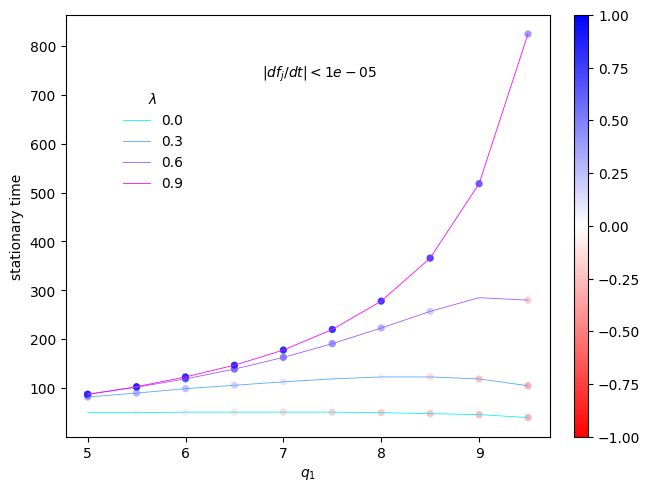

In [5]:
Nsites = 2
pi1, pi2, q2 = 0.1, 0.1, 10
q1s = [5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5]
ls = [0.0, 0.3, 0.6, 0.9]
ls_colors = plt.cm.cool(np.linspace(0.05, 0.95, len(ls)))
thresh = 1e-4


fig, ax = plt.subplots(constrained_layout=True)
ax.set(ylabel='stationary time', xlabel='$q_1$')
for l,lc in zip(ls, ls_colors):
    stat_times_fixl = []
    Qs_fixl = []
    for q1 in q1s:
        file = f'time_evo_csv_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}_Euler.csv'
        if not os.path.exists(f'{getTimeEvosPath()}/{file}'):
            intEvo(pi1, pi2, q1, q2, l, 100, ic='N', bots_per_site=(100, 0, 0), max_time = 1000)
        # if q1 == 9.5:
        #     intEvo(pi1, pi2, q1, q2, l, 100, ic='N', bots_per_site=(100, 0, 0), max_time = 2000)
        df = pd.read_csv(f'{getTimeEvosPath()}/{file}')
        df_dt = evoTimeDeriv(df, Nsites)
        # fetch stationary time, Q for each fj:
        stat_time, Q_at_stat_time = getStatTime_evoTimeDeriv(df, df_dt, thresh, Nsites)
        stat_times_fixl.append(stat_time), Qs_fixl.append(Q_at_stat_time)
    ax.plot(q1s, stat_times_fixl, label=f'{l}', lw=0.6, color=lc)
    points = ax.scatter(q1s, stat_times_fixl, c=Qs_fixl, cmap='bwr_r', vmin=-1, vmax=1, marker='.', s=70)

cb = fig.colorbar(points, aspect=30, fraction=0.10)
fig.legend(title='$\lambda$', loc=(0.18, 0.6), frameon=False)
fig.text(0.4, 0.85, rf'$|df_j /dt| < {thresh}$')
fig.savefig(f'stat_times_Euler_varq1_q2_{q2}_pi1_{pi1}_pi2_{pi2}_many_l_thresh_{thresh}.png')

### l=0.9; exponential?

0.4035313515466788


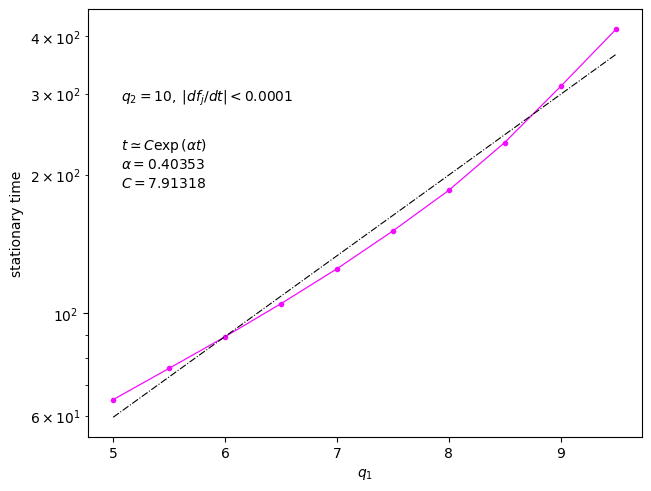

In [27]:
from scipy.stats import linregress
fig, ax = plt.subplots(constrained_layout=True)
pi1, pi2, q1, q2 = 0.1, 0.1, 9, 10
thresh = 1e-4
times = [65, 76, 89, 105, 125, 151, 185, 235, 311, 415] # times at l=0.9 and threshold 1e-4
ax.set(yscale='log', ylabel='stationary time', xlabel='$q_1$')
ax.plot(q1s, times, lw=0.9, marker='.', color=ls_colors[-1])
ln_times = np.log(np.array(times))
linParams = linregress(q1s, ln_times)
slope = linParams[0]
print(slope)
ax.plot(q1s, np.exp(slope*np.array(q1s)+linParams[1]), lw=0.8, ls='-.', color='xkcd:black')
fig.text(0.18, 0.8, rf'$q_2 = 10, \; |df_j /dt| < {thresh}$')
fig.text(0.18, 0.7, r'$t \simeq C \exp{(\alpha t)}$')
fig.text(0.18, 0.66, rf'$\alpha = {round(slope,5)}$')
fig.text(0.18, 0.62, rf'$C= {round(np.exp(linParams[1]),5)}$')
fig.savefig(f'stat_times_Euler_expoFit_q1_{q1}_q2_{q2}_pi1_{pi1}_pi2_{pi2}_l_{l}_thresh_{thresh}.png')


## Focusing on l=0.9 (or another constant l), varying q1. Let's study the effect of pi:

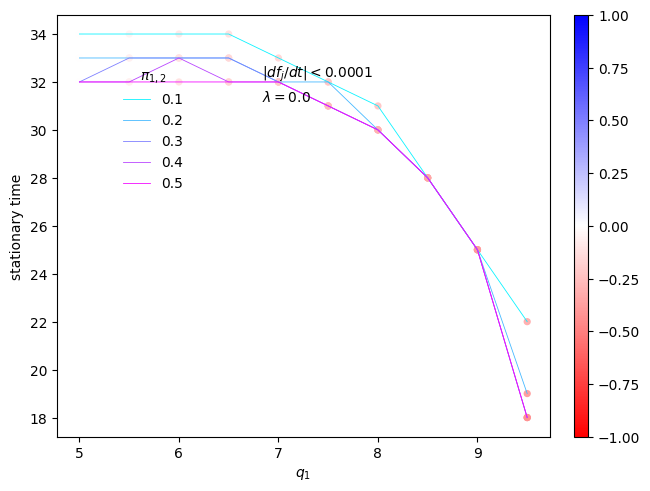

In [17]:
Nsites = 2
q2, l = 10, 0.0
q1s = [5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5]
pis = [0.1, 0.2, 0.3, 0.4, 0.5]
pis_colors = plt.cm.cool(np.linspace(0.05, 0.95, len(pis)))
thresh = 1e-4


fig, ax = plt.subplots(constrained_layout=True)
ax.set(ylabel='stationary time', xlabel='$q_1$')
for pi,pic in zip(pis, pis_colors):
    stat_times_fixPi = []
    Qs_fixPi = []
    for q1 in q1s:
        file = f'time_evo_csv_pi1_{pi}_pi2_{pi}_q1_{q1}_q2_{q2}_l_{l}_Euler.csv'
        if not os.path.exists(f'{getTimeEvosPath()}/{file}'):
            intEvo(pi, pi, q1, q2, l, 100, ic='N', bots_per_site=(100, 0, 0), max_time = 1000)
        df = pd.read_csv(f'{getTimeEvosPath()}/{file}')
        df_dt = evoTimeDeriv(df, Nsites)
        # fetch stationary time, Q for each fj:
        stat_time, Q_at_stat_time = getStatTime_evoTimeDeriv(df, df_dt, thresh, Nsites)
        stat_times_fixPi.append(stat_time), Qs_fixPi.append(Q_at_stat_time)
    ax.plot(q1s, stat_times_fixPi, label=f'{pi}', lw=0.6, color=pic)
    points = ax.scatter(q1s, stat_times_fixPi, c=Qs_fixPi, cmap='bwr_r', vmin=-1, vmax=1, marker='.', s=70)

cb = fig.colorbar(points, aspect=30, fraction=0.10)
fig.legend(title='$\pi_{1,2}$', loc=(0.18, 0.6), frameon=False)
fig.text(0.4, 0.85, rf'$|df_j /dt| < {thresh}$')
fig.text(0.4, 0.8, rf'$\lambda = {l}$')
fig.savefig(f'stat_times_Euler_varq1_q2_{q2}_l_{l}_many_pi12_thresh_{thresh}.png')

## Let's try to replicate the phase space but with convergence times instead of Q:

In [2]:
def computeTimesSymmetricMap_mesh(q1, q2, dpi=0.01, pi_lims = (0.01, 0.99), dl=0.01, l_lims = (0.00,0.99), times_thresh=1e-4):
    Npis = int((pi_lims[1] - pi_lims[0])/dpi) + 1
    Nls = int((l_lims[1] - l_lims[0])/dl) + 1
    xgrid_pi, ygrid_l = np.mgrid[pi_lims[0]:pi_lims[1]:complex(0,Npis), l_lims[0]:l_lims[1]:complex(0,Nls)]
    xgrid_pi, ygrid_l = np.around(xgrid_pi,2), np.around(ygrid_l,2)
    grid_time = np.empty([Npis, Nls])
    for i,pi in enumerate(xgrid_pi[:,0]):
        for j,l in enumerate(ygrid_l[0,:]):
            file = f'time_evo_csv_pi1_{pi}_pi2_{pi}_q1_{q1}_q2_{q2}_l_{l}_Euler.csv'
            if not os.path.exists(f'{getTimeEvosPath()}/{file}'):
                intEvo(pi, pi, q1, q2, l, 100, ic='N', bots_per_site=(100, 0, 0), max_time = 1000)
            df = pd.read_csv(f'{getTimeEvosPath()}/{file}')
            df_dt = evoTimeDeriv(df)
            # fetch stationary time, Q for each fj:
            stat_time, Q_at_stat_time = getStatTime_evoTimeDeriv(df, df_dt, times_thresh)
            grid_time[i,j] = stat_time
    if not os.path.exists(f'{getTimeEvosPath()}/stat_times_maps/'):
        call(f'mkdir {getTimeEvosPath()}/stat_times_maps/', shell=True)
    np.savez(f'{getTimeEvosPath()}/stat_times_maps/map_times_sym_q1_{q1}_q2_{q2}.npz', x=xgrid_pi, y=ygrid_l, time=grid_time)


def computeTimesAsymmetricMap_mesh_fixPi1(pi1, q1, q2, dpi2=0.01, pi2_lims = (0.01, 0.99), dl=0.01, l_lims = (0.0, 0.99), times_thresh=1e-4):
    Npi2s = int((pi2_lims[1] - pi2_lims[0])/dpi2) + 1
    Nls = int((l_lims[1]-l_lims[0])/dl) + 1
    xgrid_pi2, ygrid_l = np.mgrid[pi2_lims[0]:pi2_lims[1]:complex(0,Npi2s), l_lims[0]:l_lims[1]:complex(0,Nls)]
    xgrid_pi2, ygrid_l = np.around(xgrid_pi2, 2), np.around(ygrid_l,2)
    grid_time = np.empty([Npi2s, Nls])
    for i,pi2 in enumerate(xgrid_pi2[:,0]):
        for j,l in enumerate(ygrid_l[0,:]):
            file = f'time_evo_csv_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}_Euler.csv'
            if not os.path.exists(f'{getTimeEvosPath()}/{file}'):
                intEvo(pi1, pi2, q1, q2, l, 100, ic='N', bots_per_site=(100, 0, 0), max_time = 1000)
            df = pd.read_csv(f'{getTimeEvosPath()}/{file}')
            df_dt = evoTimeDeriv(df)
            # fetch stationary time, Q for each fj:
            stat_time, Q_at_stat_time = getStatTime_evoTimeDeriv(df, df_dt, times_thresh)
            grid_time[i,j] = stat_time
    if not os.path.exists(f'{getTimeEvosPath()}/stat_times_maps/'):
        call(f'mkdir {getTimeEvosPath()}/stat_times_maps/', shell=True)
    np.savez(f'{getTimeEvosPath()}/stat_times_maps/map_times_asym_fixPi1_q1_{q1}_q2_{q2}_pi1_{pi1}.npz', x=xgrid_pi2, y=ygrid_l, time=grid_time)

In [3]:
computeTimesSymmetricMap_mesh(5, 10, dpi=0.01, pi_lims=(0.01, 0.5), dl=0.01, l_lims=(0.01, 0.99))

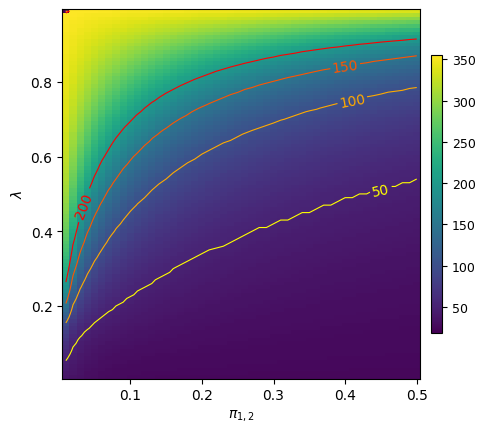

In [44]:
q1, q2 = 9, 10
map = np.load(f'{getTimeEvosPath()}/stat_times_maps/map_times_sym_q1_{q1}_q2_{q2}.npz')
fig, ax = plt.subplots(figsize=(5.6,4.8))
im = ax.pcolormesh(map['x'], map['y'], map['time'], cmap='viridis', shading='nearest')
con = ax.contour(map['x'], map['y'], map['time'], levels=[50, 100, 150, 200], linewidths=0.8, cmap='autumn_r')
ax.clabel(con)
ax.set_xlabel('$\pi_{1,2}$')
ax.set_ylabel('$\lambda$')
cb = fig.colorbar(im, ax=ax, aspect=25, shrink=0.75, pad=0.025)
cb.ax.tick_params(labelsize=9)

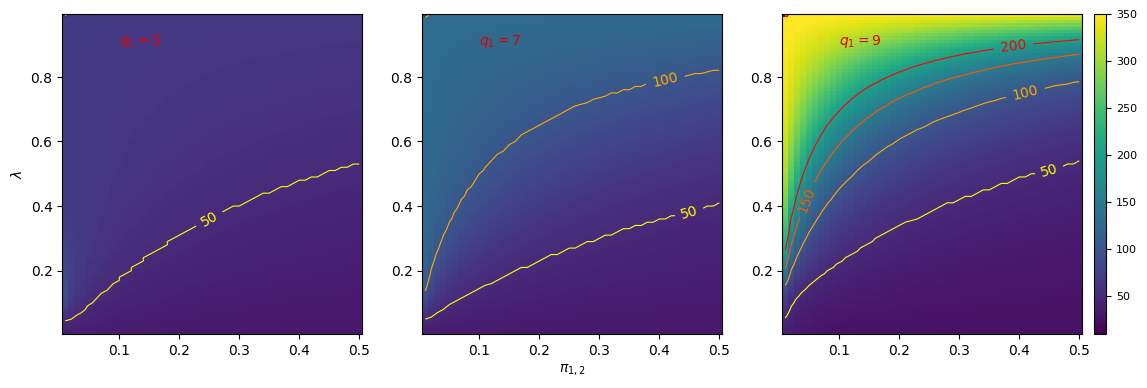

In [4]:
q1s, q2 = [5,7,9], 10

fig, ax = plt.subplots(1,3,figsize=(12,4))
for i,q1 in enumerate(q1s):
    map = np.load(f'{getTimeEvosPath()}/stat_times_maps/map_times_sym_q1_{q1}_q2_{q2}.npz')
    im = ax[i].pcolormesh(map['x'], map['y'], map['time'], cmap='viridis', shading='nearest', vmin=10, vmax=350)
    con = ax[i].contour(map['x'], map['y'], map['time'], levels=[50, 100, 150, 200], linewidths=0.8, cmap='autumn_r')
    ax[i].clabel(con)
    ax[i].text(0.1,0.90, f'$q_1 = {q1}$', color='xkcd:red')
ax[1].set_xlabel('$\pi_{1,2}$')
ax[0].set_ylabel('$\lambda$')


# Make some room for the colorbar
fig.subplots_adjust(left=0.07, right=0.92, bottom=0.125, top=0.925)
# Add the colorbar outside...
box = ax[2].get_position()
pad, width = 0.01, 0.01
cax = fig.add_axes([box.xmax + pad, box.ymin, width, box.height])
cb = fig.colorbar(im, cax=cax)
cb.ax.tick_params(labelsize=8)
fig.savefig(f'map_times_sym_q1s_multiplot_q2_{q2}.png')

In [39]:
con.allsegs[0]

[array([[0.5       , 0.53833333],
        [0.48333333, 0.53      ],
        [0.45      , 0.51      ],
        [0.4       , 0.48      ],
        [0.38333333, 0.47      ],
        [0.35      , 0.45      ],
        [0.3       , 0.42      ],
        [0.3       , 0.42      ],
        [0.25      , 0.38      ],
        [0.24      , 0.37      ],
        [0.2       , 0.33571429],
        [0.175     , 0.31      ],
        [0.15      , 0.285     ],
        [0.13333333, 0.26      ],
        [0.1       , 0.2225    ],
        [0.09375   , 0.21      ],
        [0.055     , 0.16      ],
        [0.05      , 0.15454545]])]

In [18]:
computeTimesAsymmetricMap_mesh_fixPi1(0.25, 9, 10, dpi2=0.05, pi2_lims = (0.05, 0.5), dl=0.05, l_lims = (0.0, 0.95))

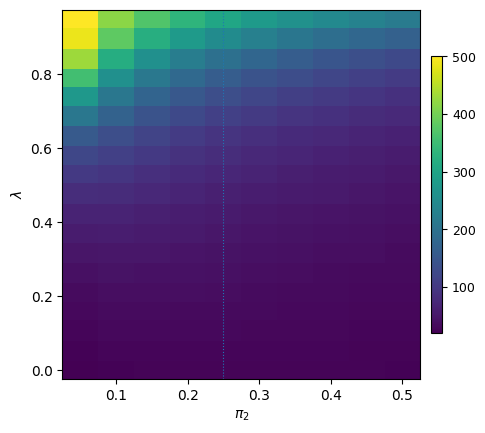

In [19]:
pi1, q1, q2 = 0.25, 9, 10
map = np.load(f'{getTimeEvosPath()}/stat_times_maps/map_times_asym_fixPi1_q1_{q1}_q2_{q2}_pi1_{pi1}.npz')
fig, ax = plt.subplots(figsize=(5.6,4.8))
im = ax.pcolormesh(map['x'], map['y'], map['time'], cmap='viridis', shading='nearest')
ax.set_xlabel('$\pi_{2}$')
ax.set_ylabel('$\lambda$')
ax.axvline(0.25, 0, 1, ls=':', lw=0.8)
cb = fig.colorbar(im, ax=ax, aspect=25, shrink=0.75, pad=0.025)
cb.ax.tick_params(labelsize=9)